In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# import warnings
# warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

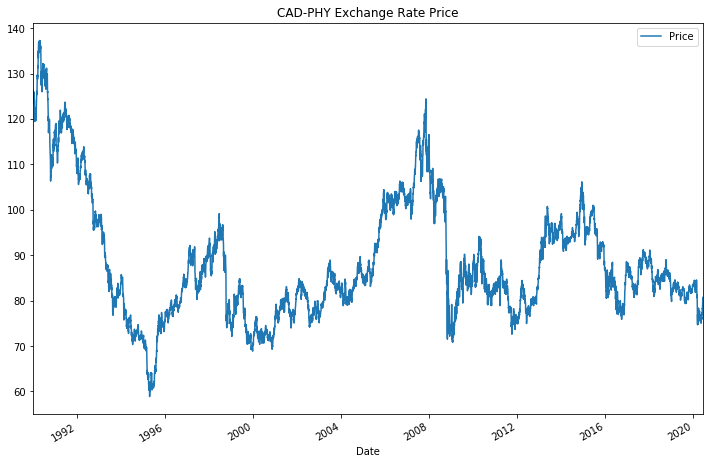

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(title="CAD-PHY Exchange Rate Price", figsize=(12,8), legend=True)

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** <br> Overall, from the graph, the exhange rate price fluctures around it's average, the trend is relatively stable. <br> In the short-term,  there is no seasonal patteren for each year. <br> For the long-term, the exchange rate price cycles from low to low every six to eight years. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
import statsmodels.api as sm
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df.Price)  

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
hp_df = pd.DataFrame()
hp_df["Price"]=cad_jpy_df.Price
hp_df["Noise"]=ts_noise
hp_df["Trend"]=ts_trend
hp_df.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


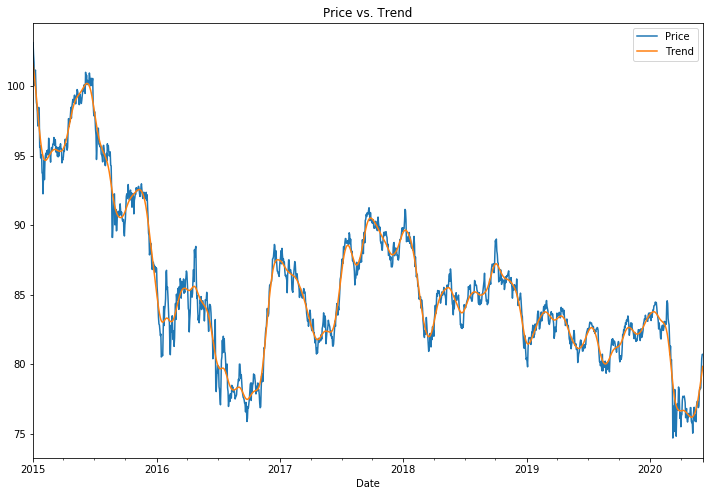

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
hp_df['2015':][['Price','Trend']].plot(title='Price vs. Trend', figsize=(12,8), legend=True)

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** <br> There is no clear patterns. <br> But it could be noticeable that the exchange rate prices were close for the beginning and the end of each year. <br> And overall, for this five year period, there was a slighly decreasing trend.

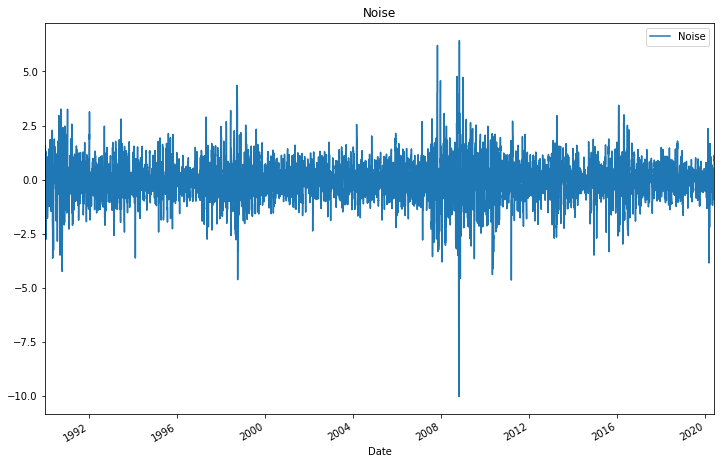

In [8]:
# Plot the Settle Noise
hp_df.Noise.plot(title='Noise', figsize=(12,8), legend=True)

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [15]:
# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA
# Create the ARMA model using the return values and the order
model_aram = ARMA(returns.values, order=(2,1))
# Fit the model to the data
aram_results = model_aram.fit()    
# Output model summary results: 
aram_results.summary()                        

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Fri, 22 Jan 2021   AIC                          19513.955
Time:                        00:29:21   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2034           +0.0000j            1.2034            0.5000
AR.2          -42.1705           +0.0000j           42.1705            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

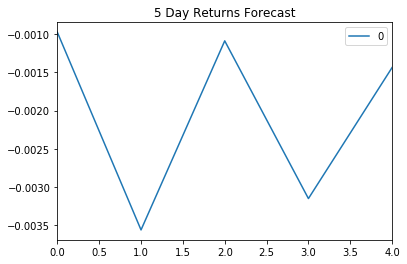

In [16]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(aram_results.forecast(steps=5)[0]).plot(title= '5 Day Returns Forecast')

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The p-value for AR lag one and MA lag one are less than 0.05, thus, these coefficients are statistically significant. <br> Whereas, the p-value for AR lag two is 0.14 which is greater than 0.05, suggesting this coefficient is not statistically significant.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [17]:
# Create an ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model_ariam = ARIMA(returns.values, order=(5,1,1))
# Fit the model to the data
ariam_results = model_ariam.fit()
# Print the model summary
ariam_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7927
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9754.577
Method:                       css-mle   S.D. of innovations              0.828
Date:                Fri, 22 Jan 2021   AIC                          19525.154
Time:                        00:29:48   BIC                          19580.979
Sample:                             1   HQIC                         19544.271
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.838e-06   4.75e-06      0.598      0.550   -6.47e-06    1.21e-05
ar.L1.D.y     -0.0235      0.011     -2.093      0.036      -0.046      -0.001
ar.L2.D.y      0.0024      0.011      0.213      0.831      -0.020       0.024
ar.L3.D.y     -0.0074      0.011     -0.654      0.513      -0.029       0.015
ar.L4.D.y      0.0038      0.011      0.338      0.735      -0.018       0.026
ar.L5.D.y     -0.0161      0.011     -1.430      0.153      -0.038       0.006
ma.L1.D.y     -0.9997      0.001  -1555.224      0.000      -1.001      -0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1724           -0.0000j            2.1724           -0.5000
AR.2           -0.6690           -2.1977j            2.2972           -0.2970
AR.3           -0.6690           +2.1977j            2.2972            0.2970
AR.4            1.8736           -1.3847j            2.3297           -0.1013
AR.5            1.8736           +1.3847j            2.3297            0.1013
MA.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

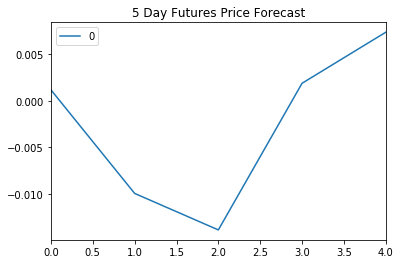

In [18]:
# Plot the Futures Price Forecast
pd.DataFrame(ariam_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** YOUR ANSWER HERE

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [22]:
# Create an GARCH model
from arch import arch_model
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
garch_results = model_garch.fit(disp= 'on')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 569545243.4284524
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838552966728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11769.086094978014
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.350185312931
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.366479560163
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.111921464748
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027336222945
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.02203125968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021014202204
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020776838068
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764888566
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.02076489123


In [23]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Fri, Jan 22 2021   Df Residuals:                     7924
Time:                        00:31:50   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [25]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [27]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [28]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [31]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04 00:00:00
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


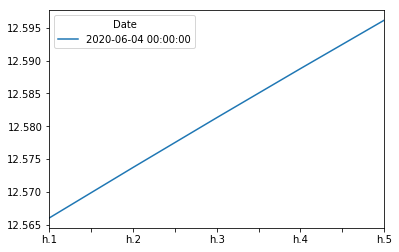

In [30]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model forecast the volatility will increase over next five days.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * YOUR ANSWER HERE

2. Is the risk of the yen expected to increase or decrease?
    * YOUR ANSWER HERE

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * YOUR ANSWER HERE